# Statistical Analysis

[This notebook](https://github.com/dattalab/keypoint-moseq/blob/main/docs/source/analysis.ipynb) contains routines for analyzing the output of keypoint-MoSeq.

```{note}
The interactive widgets require jupyterlab launched from the `keypoint_moseq` environment. They will not work properly in jupyter notebook.
```


## Setup

We assume you have already have keypoint-MoSeq outputs that are organized as follows.
```
<project_dir>/               ** current working directory
└── <model_name>/            ** model directory
    ├── results.h5           ** model results
    └── grid_movies/         ** [Optional] grid movies folder
```
Use the code below to enter in your project directory and model name.

In [1]:
import keypoint_moseq as kpms

project_dir=r'C:\Users\MyPC\Desktop\git\kp_moseq\keypoint-moseq\project\SDSBD\dataset5\trainset1' # the full path to the project directory
model_name='2024_01_04-13_41_21' # name of model to analyze (e.g. something like `2023_05_23-15_19_03`)
fps=20 # frames per second of the video

## Assign Groups

The goal of this step is to assign group labels (such as "mutant" or "wildtype") to each recording. These labels are important later for performing group-wise comparisons.
- The code below creates a table called `{project_dir}/index.csv` and launches a widget for editing the table. To use the widget:
    - Click cells in the "group" column and enter new group labels.
    - Hit `Save group info` when you're done.
- **If the widget doesn't appear**, you also edit the table directly in Excel or LibreOffice Calc.

In [2]:
kpms.interactive_group_setting(project_dir, model_name, index_filename='index.csv')

BokehModel(combine_events=True, render_bundle={'docs_json': {'7f4e0b0b-cc65-424c-ac0b-cf97b57f941c': {'version…

KeyError: 'data'

KeyError: 'data'

## Generate dataframes

Generate a pandas dataframe called `moseq_df` that contains syllable labels and kinematic information for each frame across all the recording sessions. 

In [3]:
#  CSV 파일의 'name' 컬럼에 있는 값들과 일치하는 키만 포함하는 새로운 dictionary를 만들어 return하는 코드
 
import csv

def extract_matching_results(csv_file, results_dict):
    # CSV 파일에서 name 컬럼의 값들을 읽어옵니다
    with open(csv_file, 'r', encoding='utf-8') as file:
        reader = csv.DictReader(file)
        names_in_csv = set(row['name'] for row in reader)
    
    # results_dict에서 CSV의 name과 일치하는 키-값 쌍만 추출합니다
    new_dict = {key: value for key, value in results_dict.items() if key in names_in_csv}
    
    return new_dict

In [4]:
import os
index_filename = "index_z1.5.csv"

results_dict = kpms.load_results(project_dir, model_name)
results_dict = extract_matching_results(csv_file=os.path.join(project_dir,index_filename), results_dict=results_dict)
moseq_df = kpms.compute_moseq_df(project_dir, model_name, results_dict=results_dict, fps=fps, smooth_heading=True, index_filename=index_filename) 
moseq_df

,name,centroid_x,centroid_y,centroid_z,heading,angular_velocity,velocity_px_s,syllable,frame_index,group,onset
0,pre101,-4.890107,5.460056,1.800803,0.423362,0.000000,0.000000,7,0,control,True
1,pre101,-4.269766,5.373690,0.887762,0.452157,0.140808,22.144306,7,1,control,False
2,pre101,-4.569123,5.635958,1.173214,0.423362,0.297305,9.795562,7,2,control,False
3,pre101,-4.900844,5.466158,1.408959,0.452157,0.475994,8.819206,7,3,control,False
4,pre101,-4.684514,5.418027,1.637164,0.452157,0.668536,6.362174,7,4,control,False
...,...,...,...,...,...,...,...,...,...,...,...
896795,pre515,7.301109,-7.684746,4.589743,-0.685434,-0.536681,17.367390,2,11795,susceptible,False
896796,pre515,7.286511,-7.731138,4.522948,-0.716127,-0.418509,1.652496,2,11796,susceptible,False
896797,pre515,7.020144,-7.343358,4.684829,-0.716127,-0.308097,9.950481,2,11797,susceptible,False
896798,pre515,6.738294,-6.960769,4.991628,-0.758452,-0.203938,11.312629,2,11798,susceptible,False


Next generate a dataframe called `stats_df` that contains summary statistics for each syllable in each recording session, such as its usage frequency and its distribution of kinematic parameters.

In [10]:
import os
import pandas as pd
index_filename = "index_z1.5.csv"
moseq_df_filename = 'moseq_df_z1.5_scalars_rectify.csv'
results_dict = kpms.load_results(project_dir, model_name)
results_dict = extract_matching_results(csv_file=os.path.join(project_dir,index_filename), results_dict=results_dict)
index_filename = index_filename
min_frequency = 0.01

moseq_df = pd.read_csv(os.path.join(project_dir, model_name, moseq_df_filename), encoding='utf-8')
features_col = ["heading", "angular_velocity", "velocity_px_s", 
                "distance_from_origin", "velocity_xy", "velocity_z","length", "height", "torso_angle","angle_to_origin"]

stats_df = kpms.compute_stats_df(
    project_dir,
    model_name,
    moseq_df, 
    results_dict=results_dict,
    min_frequency=min_frequency,       # threshold frequency for including a syllable in the dataframe
    groupby=['group', 'name'], # column(s) to group the dataframe by
    fps=fps,
    index_filename=index_filename,
    features_col=features_col
    )                    # frame rate of the video from which keypoints were inferred

stats_df

,group,name,syllable,heading_mean,heading_std,heading_min,heading_max,angular_velocity_mean,angular_velocity_std,angular_velocity_min,...,torso_angle_mean,torso_angle_std,torso_angle_min,torso_angle_max,angle_to_origin_mean,angle_to_origin_std,angle_to_origin_min,angle_to_origin_max,frequency,duration
0,control,pre101,0,0.300114,1.743290,-3.065187,3.126728,0.041151,6.183400,-124.841955,...,1.724026,1.359068,0.000780,3.141055,1.985370,0.799092,0.005464,3.139843,0.121726,0.525949
1,control,pre101,1,0.192304,1.486307,-3.137526,3.114187,0.123514,6.251990,-122.839748,...,1.770177,1.206371,0.002284,3.140380,1.512998,0.673831,0.022577,3.139754,0.077042,0.403000
2,control,pre101,2,0.305774,1.851624,-3.121521,3.113962,-0.053589,11.705295,-125.537627,...,1.767611,1.179903,0.001315,3.141214,1.821337,0.710959,0.000315,3.135014,0.072419,0.369149
3,control,pre101,3,-0.036918,1.882042,-3.125108,3.133265,0.129068,10.886630,-125.438351,...,1.583414,1.407583,0.001096,3.140590,1.979760,0.726687,0.005525,3.137827,0.070878,0.722826
4,control,pre101,4,-0.087757,1.867114,-3.129096,3.135656,0.016667,11.494598,-125.091086,...,1.490511,1.332433,0.000638,3.141373,1.701876,0.759618,0.041481,3.124065,0.084746,1.069091
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1495,susceptible,pre515,15,-0.905697,1.324931,-2.395697,2.350345,0.150789,0.362615,-0.446533,...,2.327469,1.285386,0.006784,3.128996,1.315258,0.827974,0.154883,2.618166,0.005076,0.960000
1496,susceptible,pre515,17,-0.612740,1.902266,-2.557037,2.978161,-0.490278,0.868048,-2.846438,...,1.024051,0.677709,0.068990,3.106745,1.358991,0.592300,0.134187,3.119103,0.009137,0.888889
1497,susceptible,pre515,18,-0.287941,2.311465,-3.093878,3.114922,0.160539,10.439447,-125.275594,...,2.131837,0.838607,0.003222,3.097872,0.875204,0.447700,0.020527,1.666807,0.016244,0.909375
1498,susceptible,pre515,23,2.632228,0.253962,2.224416,2.839604,1.392337,0.468993,0.634371,...,2.887058,0.115092,2.732507,3.048363,1.626846,0.206582,1.414709,1.992649,0.001015,0.450000


### **Optional:** Save dataframes to csv
Uncomment the code below to save the dataframes as .csv files

In [11]:
import os
stats_output_filename = 'stats_df_z1.5_scalars_rectify.csv'

# save stats_df
save_dir = os.path.join(project_dir, model_name)
stats_df.to_csv(os.path.join(save_dir, stats_output_filename), index=False, encoding='utf-8')
print('Saved `stats_df` dataframe to', save_dir)

Saved `stats_df` dataframe to C:\Users\MyPC\Desktop\git\kp_moseq\keypoint-moseq\project\SDSBD\dataset5\trainset1\2024_01_04-13_41_21


In [5]:
# import os
# moseq_output_filename = 'moseq_df_z1.5.csv'
# stats_output_filename = 'stats_df_z1.5.csv'


# # save moseq_df
# save_dir = os.path.join(project_dir, model_name) # directory to save the moseq_df dataframe
# moseq_df.to_csv(os.path.join(save_dir, moseq_output_filename), index=False, encoding='utf-8')
# print(f'Saved `moseq_df` dataframe to', save_dir)

# # save stats_df
# save_dir = os.path.join(project_dir, model_name)
# stats_df.to_csv(os.path.join(save_dir, stats_output_filename), index=False, encoding='utf-8')
# print('Saved `stats_df` dataframe to', save_dir)

Saved `moseq_df` dataframe to C:\Users\MyPC\Desktop\git\kp_moseq\keypoint-moseq\project\SDSBD\dataset5\trainset1\2024_01_04-13_41_21
Saved `stats_df` dataframe to C:\Users\MyPC\Desktop\git\kp_moseq\keypoint-moseq\project\SDSBD\dataset5\trainset1\2024_01_04-13_41_21


##  Label syllables

The goal of this step is name each syllable (e.g., "rear up" or "walk slowly").
- The code below creates an empty table at `{project_dir}/{model_name}/syll_info.csv` and launches an interactive widget for editing the table. To use the widget:
    - Select a syllable from the dropdown to display its grid movie.
    - Enter a name into the `label` column of the table (and optionally a short description too).
    - When you are done, hit `Save syllable info` at the bottom of the table.
- **If the widget doesn't appear**, you can also edit the file directly in Excel or LibreOffice Calc.

In [ ]:
kpms.label_syllables(project_dir, model_name, moseq_df) 

## Compare between groups

Test for statistically significant differences between groups of recordings. The code below takes a syllable property (e.g. frequency or duration), plots its disribution for each syllable across for each group, and also tests whether the property differs significantly between groups. The results are summarized in a plot that is saved to `{project_dir}/{model_name}/analysis_figures`.

There are two options for setting the order of syllables along the x-axis. When `order='stat'`, syllables are sorted by the mean value of the statistic. When `order='diff'`, syllables are sorted by the magnitude of difference between two groups that are determined by the `ctrl_group` and `exp_group` keywords. Note `ctrl_group` and `exp_group` are not related to significance testing.

(Warning) stats_subtle_df에 있는 모든 group간 통계비교를 함.
만약 stats_subtle_df에 프로젝트 내 여러 group들이 섞여 있어서 통계비교를 원하지 않는다면 아래와 같이 원하는 그룹만 따로 추출하는 과정이 필요함.

In [1]:
import keypoint_moseq as kpms
import os
import pandas as pd

project_dir=r'C:\Users\MyPC\Desktop\git\kp_moseq\keypoint-moseq\project\SDSBD\dataset5\trainset1' # the full path to the project directory
model_name='2024_01_04-13_41_21' # name of model to analyze (e.g. something like `2023_05_23-15_19_03`)
fps=20 # frames per second of the video
ctrl_group='susceptible'
exp_group='resilient'
stats_df_filename = 'stats_df_z1.5_scalars_rectify.csv' 


groups = [ctrl_group, exp_group] # groups to be plotted
stats_df = pd.read_csv(os.path.join(project_dir, model_name, stats_df_filename), encoding='utf-8')
stats_df = stats_df[stats_df['group'].isin(groups)]
stats_df

,group,name,syllable,heading_mean,heading_std,heading_min,heading_max,angular_velocity_mean,angular_velocity_std,angular_velocity_min,...,torso_angle_mean,torso_angle_std,torso_angle_min,torso_angle_max,angle_to_origin_mean,angle_to_origin_std,angle_to_origin_min,angle_to_origin_max,frequency,duration
376,resilient,pre102,0,-0.192644,1.848216,-3.117649,3.135957,-0.102431,10.114976,-124.236943,...,1.217973,1.331588,0.000271,3.140388,1.927142,0.722045,0.000356,3.139874,0.130435,0.493056
377,resilient,pre102,1,-0.024941,1.745981,-3.136276,3.131011,-0.359461,12.642252,-125.534052,...,1.461790,1.252177,0.008630,3.138920,1.500389,0.731617,0.003628,3.140778,0.101449,0.347024
378,resilient,pre102,2,0.183220,1.746224,-3.139859,3.127324,0.177593,9.568129,-124.963104,...,1.549367,1.120874,0.000807,3.140387,1.688466,0.878990,0.013018,3.138214,0.065217,0.477778
379,resilient,pre102,3,0.301866,1.794843,-3.140285,3.138301,-0.277193,8.925764,-124.369298,...,1.277723,1.406503,0.000363,3.141567,1.860412,0.660658,0.004319,3.122311,0.085749,0.695775
380,resilient,pre102,4,0.294351,2.004163,-3.135358,3.141584,0.379439,12.194261,-125.024577,...,1.277806,1.259810,0.000355,3.141562,1.693075,0.745772,0.002667,3.141024,0.078502,0.968462
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1495,susceptible,pre515,15,-0.905697,1.324931,-2.395697,2.350345,0.150789,0.362615,-0.446533,...,2.327469,1.285386,0.006784,3.128996,1.315258,0.827974,0.154883,2.618166,0.005076,0.960000
1496,susceptible,pre515,17,-0.612740,1.902266,-2.557037,2.978161,-0.490278,0.868048,-2.846438,...,1.024051,0.677709,0.068990,3.106745,1.358991,0.592300,0.134187,3.119103,0.009137,0.888889
1497,susceptible,pre515,18,-0.287941,2.311465,-3.093878,3.114922,0.160539,10.439447,-125.275594,...,2.131837,0.838607,0.003222,3.097872,0.875204,0.447700,0.020527,1.666807,0.016244,0.909375
1498,susceptible,pre515,23,2.632228,0.253962,2.224416,2.839604,1.392337,0.468993,0.634371,...,2.887058,0.115092,2.732507,3.048363,1.626846,0.206582,1.414709,1.992649,0.001015,0.450000


c:\Users\MyPC\anaconda3\envs\keypoint_moseq\lib\site-packages\keypoint_moseq\analysis.py:1174: UserWarning:



The `join` parameter is deprecated and will be removed in v0.15.0. You can remove the line between points with `linestyle='none'`.


c:\Users\MyPC\anaconda3\envs\keypoint_moseq\lib\site-packages\seaborn\_base.py:948: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.

c:\Users\MyPC\anaconda3\envs\keypoint_moseq\lib\site-packages\seaborn\_base.py:948: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.



No significant syllables found.
Saved figure to C:\Users\MyPC\Desktop\git\kp_moseq\keypoint-moseq\project\SDSBD\dataset5\trainset1\2024_01_04-13_41_21\figures\distance_from_origin_mean_frequency_stats.png


c:\Users\MyPC\anaconda3\envs\keypoint_moseq\lib\site-packages\keypoint_moseq\analysis.py:1174: UserWarning:



The `join` parameter is deprecated and will be removed in v0.15.0. You can remove the line between points with `linestyle='none'`.


c:\Users\MyPC\anaconda3\envs\keypoint_moseq\lib\site-packages\seaborn\_base.py:948: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.

c:\Users\MyPC\anaconda3\envs\keypoint_moseq\lib\site-packages\seaborn\_base.py:948: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.



No significant syllables found.
Saved figure to C:\Users\MyPC\Desktop\git\kp_moseq\keypoint-moseq\project\SDSBD\dataset5\trainset1\2024_01_04-13_41_21\figures\velocity_xy_mean_frequency_stats.png


c:\Users\MyPC\anaconda3\envs\keypoint_moseq\lib\site-packages\keypoint_moseq\analysis.py:1174: UserWarning:



The `join` parameter is deprecated and will be removed in v0.15.0. You can remove the line between points with `linestyle='none'`.


c:\Users\MyPC\anaconda3\envs\keypoint_moseq\lib\site-packages\seaborn\_base.py:948: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.

c:\Users\MyPC\anaconda3\envs\keypoint_moseq\lib\site-packages\seaborn\_base.py:948: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.



No significant syllables found.
Saved figure to C:\Users\MyPC\Desktop\git\kp_moseq\keypoint-moseq\project\SDSBD\dataset5\trainset1\2024_01_04-13_41_21\figures\velocity_z_mean_frequency_stats.png


c:\Users\MyPC\anaconda3\envs\keypoint_moseq\lib\site-packages\keypoint_moseq\analysis.py:1174: UserWarning:



The `join` parameter is deprecated and will be removed in v0.15.0. You can remove the line between points with `linestyle='none'`.


c:\Users\MyPC\anaconda3\envs\keypoint_moseq\lib\site-packages\seaborn\_base.py:948: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.

c:\Users\MyPC\anaconda3\envs\keypoint_moseq\lib\site-packages\seaborn\_base.py:948: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.



No significant syllables found.
Saved figure to C:\Users\MyPC\Desktop\git\kp_moseq\keypoint-moseq\project\SDSBD\dataset5\trainset1\2024_01_04-13_41_21\figures\length_mean_frequency_stats.png


c:\Users\MyPC\anaconda3\envs\keypoint_moseq\lib\site-packages\keypoint_moseq\analysis.py:1174: UserWarning:



The `join` parameter is deprecated and will be removed in v0.15.0. You can remove the line between points with `linestyle='none'`.


c:\Users\MyPC\anaconda3\envs\keypoint_moseq\lib\site-packages\seaborn\_base.py:948: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.

c:\Users\MyPC\anaconda3\envs\keypoint_moseq\lib\site-packages\seaborn\_base.py:948: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.



No significant syllables found.
Saved figure to C:\Users\MyPC\Desktop\git\kp_moseq\keypoint-moseq\project\SDSBD\dataset5\trainset1\2024_01_04-13_41_21\figures\height_mean_frequency_stats.png


c:\Users\MyPC\anaconda3\envs\keypoint_moseq\lib\site-packages\keypoint_moseq\analysis.py:1174: UserWarning:



The `join` parameter is deprecated and will be removed in v0.15.0. You can remove the line between points with `linestyle='none'`.


c:\Users\MyPC\anaconda3\envs\keypoint_moseq\lib\site-packages\seaborn\_base.py:948: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.

c:\Users\MyPC\anaconda3\envs\keypoint_moseq\lib\site-packages\seaborn\_base.py:948: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.



No significant syllables found.
Saved figure to C:\Users\MyPC\Desktop\git\kp_moseq\keypoint-moseq\project\SDSBD\dataset5\trainset1\2024_01_04-13_41_21\figures\torso_angle_mean_frequency_stats.png


c:\Users\MyPC\anaconda3\envs\keypoint_moseq\lib\site-packages\keypoint_moseq\analysis.py:1174: UserWarning:



The `join` parameter is deprecated and will be removed in v0.15.0. You can remove the line between points with `linestyle='none'`.


c:\Users\MyPC\anaconda3\envs\keypoint_moseq\lib\site-packages\seaborn\_base.py:948: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.

c:\Users\MyPC\anaconda3\envs\keypoint_moseq\lib\site-packages\seaborn\_base.py:948: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.



No significant syllables found.
Saved figure to C:\Users\MyPC\Desktop\git\kp_moseq\keypoint-moseq\project\SDSBD\dataset5\trainset1\2024_01_04-13_41_21\figures\angle_to_origin_mean_frequency_stats.png


c:\Users\MyPC\anaconda3\envs\keypoint_moseq\lib\site-packages\keypoint_moseq\analysis.py:1174: UserWarning:



The `join` parameter is deprecated and will be removed in v0.15.0. You can remove the line between points with `linestyle='none'`.


c:\Users\MyPC\anaconda3\envs\keypoint_moseq\lib\site-packages\seaborn\_base.py:948: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.

c:\Users\MyPC\anaconda3\envs\keypoint_moseq\lib\site-packages\seaborn\_base.py:948: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.



Saved figure to C:\Users\MyPC\Desktop\git\kp_moseq\keypoint-moseq\project\SDSBD\dataset5\trainset1\2024_01_04-13_41_21\figures\frequency_frequency_stats.png


c:\Users\MyPC\anaconda3\envs\keypoint_moseq\lib\site-packages\keypoint_moseq\analysis.py:1174: UserWarning:



The `join` parameter is deprecated and will be removed in v0.15.0. You can remove the line between points with `linestyle='none'`.


c:\Users\MyPC\anaconda3\envs\keypoint_moseq\lib\site-packages\seaborn\_base.py:948: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.

c:\Users\MyPC\anaconda3\envs\keypoint_moseq\lib\site-packages\seaborn\_base.py:948: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.



No significant syllables found.
Saved figure to C:\Users\MyPC\Desktop\git\kp_moseq\keypoint-moseq\project\SDSBD\dataset5\trainset1\2024_01_04-13_41_21\figures\duration_frequency_stats.png


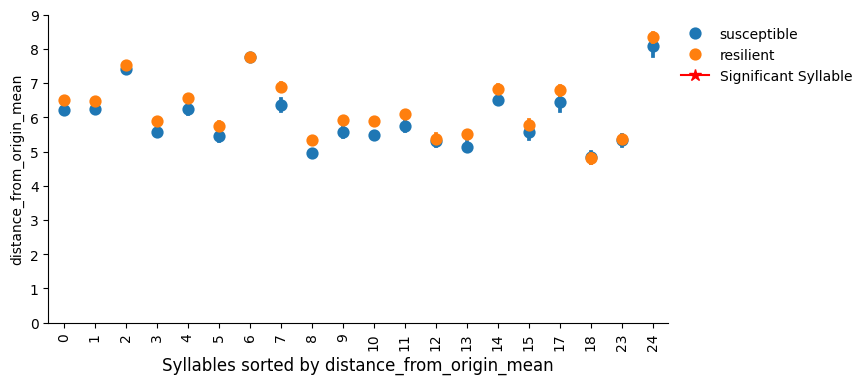

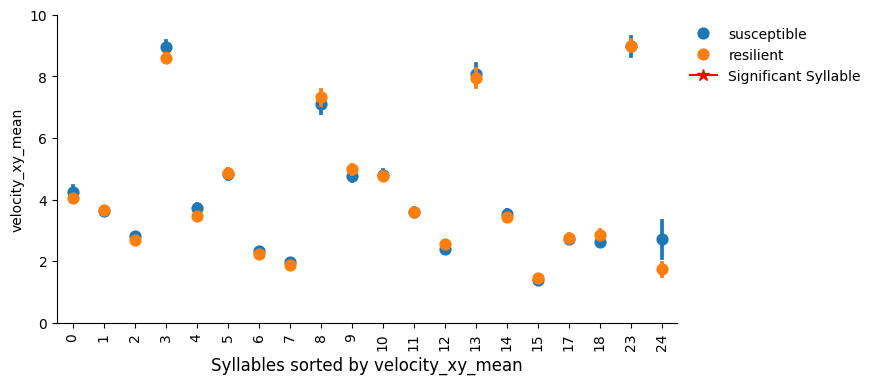

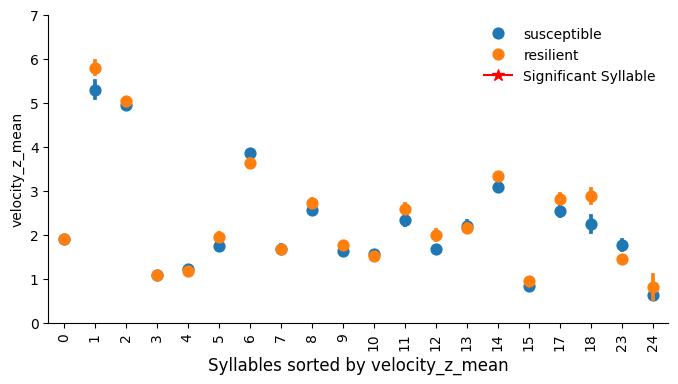

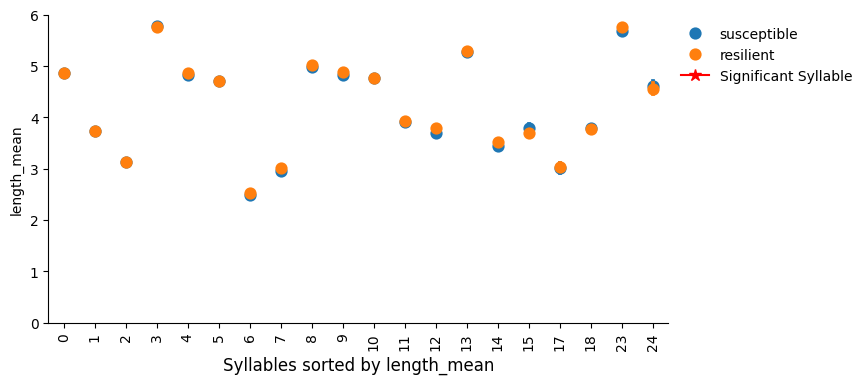

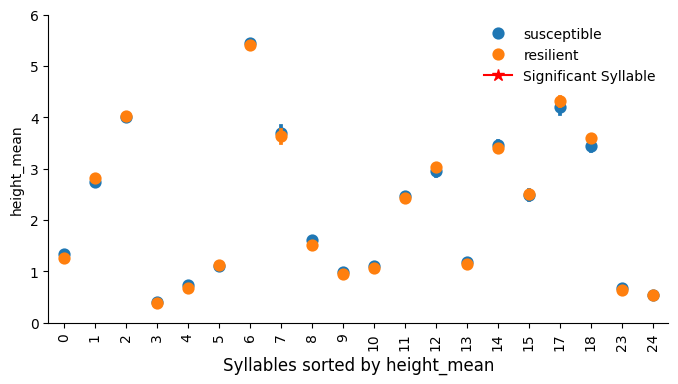

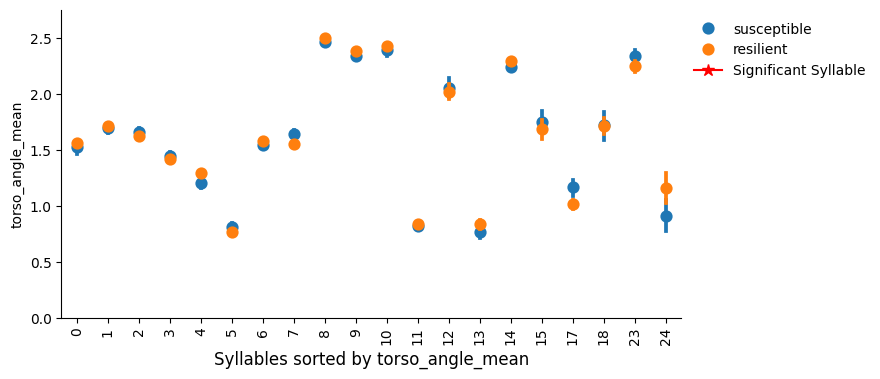

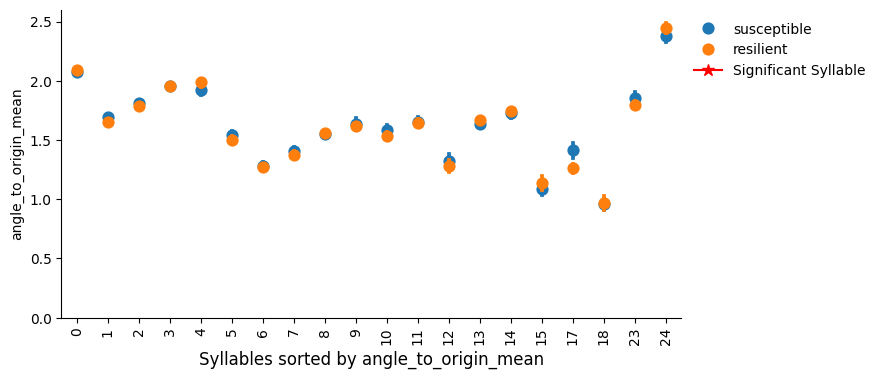

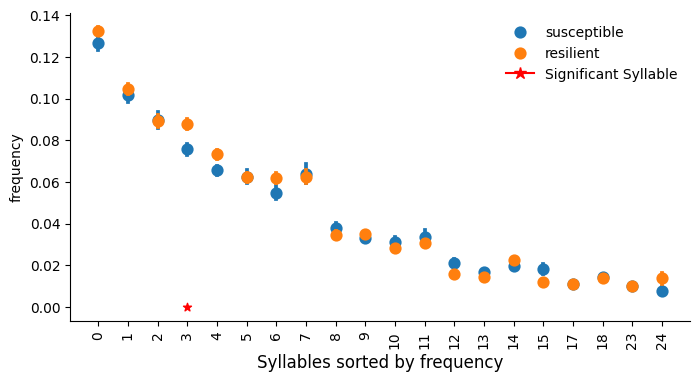

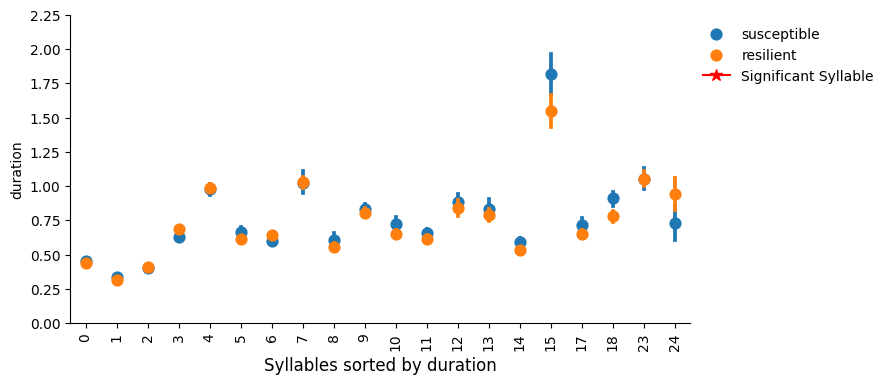

In [2]:
thresh=0.05   # Q value for statistical significance (bh-fdr correction)
#stats = ['frequency', 'duration', 'distance_from_origin_mean','velocity_xy_mean','velocity_z_mean','length_mean','height_mean','torso_angle_mean']
stats = ['distance_from_origin','velocity_xy','velocity_z','length','height','torso_angle','angle_to_origin']
# postfix = ['mean', 'std','max','min']
postfix = ['mean']
stats2 = [f'{stat}_{post}' for stat in stats for post in postfix]
stats2 = stats2 + ['frequency','duration']

for stat in stats2:
    kpms.plot_syll_stats_with_sem(
    stats_df, project_dir, model_name,
    plot_sig=True,    # whether to mark statistical significance with a star
    thresh=thresh,      # significance threshold
    stat=stat, #statistic to be plotted (e.g. 'duration' or 'velocity_px_s_mean')
    order='frequency',     # order syllables by overall frequency ("stat") or degree of difference ("diff"), syllable순서대로("frequency")
    ctrl_group=ctrl_group,   # name of the control group for statistical testing
    exp_group=exp_group,    # name of the experimental group for statistical testing
    figsize=(8, 4),   # figure size    
    join=False,   # whether to join syllables with a line
    groups=groups, # groups to be plotted
    #groups=stats_df['group'].unique(), # groups to be plotted
    mc_method='fdr_bh' # multiple comparison correction method ('hs' for Hochberg-Sidak, 'fdr_bh' for Benjamini-Hochberg)
    )

c:\Users\MyPC\anaconda3\envs\keypoint_moseq\lib\site-packages\keypoint_moseq\analysis.py:1171: UserWarning:



The `join` parameter is deprecated and will be removed in v0.15.0. You can remove the line between points with `linestyle='none'`.




No significant syllables found.
Saved figure to C:\Users\MyPC\Desktop\git\kp_moseq\keypoint-moseq\project\SDSBD\dataset5\trainset1\2024_01_04-13_41_21\figures\heading_mean_stat_stats.png


c:\Users\MyPC\anaconda3\envs\keypoint_moseq\lib\site-packages\keypoint_moseq\analysis.py:1171: UserWarning:



The `join` parameter is deprecated and will be removed in v0.15.0. You can remove the line between points with `linestyle='none'`.




No significant syllables found.
Saved figure to C:\Users\MyPC\Desktop\git\kp_moseq\keypoint-moseq\project\SDSBD\dataset5\trainset1\2024_01_04-13_41_21\figures\heading_std_stat_stats.png


c:\Users\MyPC\anaconda3\envs\keypoint_moseq\lib\site-packages\keypoint_moseq\analysis.py:1171: UserWarning:



The `join` parameter is deprecated and will be removed in v0.15.0. You can remove the line between points with `linestyle='none'`.




No significant syllables found.
Saved figure to C:\Users\MyPC\Desktop\git\kp_moseq\keypoint-moseq\project\SDSBD\dataset5\trainset1\2024_01_04-13_41_21\figures\heading_min_stat_stats.png


c:\Users\MyPC\anaconda3\envs\keypoint_moseq\lib\site-packages\keypoint_moseq\analysis.py:1171: UserWarning:



The `join` parameter is deprecated and will be removed in v0.15.0. You can remove the line between points with `linestyle='none'`.




No significant syllables found.
Saved figure to C:\Users\MyPC\Desktop\git\kp_moseq\keypoint-moseq\project\SDSBD\dataset5\trainset1\2024_01_04-13_41_21\figures\heading_max_stat_stats.png


c:\Users\MyPC\anaconda3\envs\keypoint_moseq\lib\site-packages\keypoint_moseq\analysis.py:1171: UserWarning:



The `join` parameter is deprecated and will be removed in v0.15.0. You can remove the line between points with `linestyle='none'`.




No significant syllables found.
Saved figure to C:\Users\MyPC\Desktop\git\kp_moseq\keypoint-moseq\project\SDSBD\dataset5\trainset1\2024_01_04-13_41_21\figures\angular_velocity_mean_stat_stats.png


c:\Users\MyPC\anaconda3\envs\keypoint_moseq\lib\site-packages\keypoint_moseq\analysis.py:1171: UserWarning:



The `join` parameter is deprecated and will be removed in v0.15.0. You can remove the line between points with `linestyle='none'`.




No significant syllables found.
Saved figure to C:\Users\MyPC\Desktop\git\kp_moseq\keypoint-moseq\project\SDSBD\dataset5\trainset1\2024_01_04-13_41_21\figures\angular_velocity_std_stat_stats.png


c:\Users\MyPC\anaconda3\envs\keypoint_moseq\lib\site-packages\keypoint_moseq\analysis.py:1171: UserWarning:



The `join` parameter is deprecated and will be removed in v0.15.0. You can remove the line between points with `linestyle='none'`.




No significant syllables found.
Saved figure to C:\Users\MyPC\Desktop\git\kp_moseq\keypoint-moseq\project\SDSBD\dataset5\trainset1\2024_01_04-13_41_21\figures\angular_velocity_min_stat_stats.png


c:\Users\MyPC\anaconda3\envs\keypoint_moseq\lib\site-packages\keypoint_moseq\analysis.py:1171: UserWarning:



The `join` parameter is deprecated and will be removed in v0.15.0. You can remove the line between points with `linestyle='none'`.




No significant syllables found.
Saved figure to C:\Users\MyPC\Desktop\git\kp_moseq\keypoint-moseq\project\SDSBD\dataset5\trainset1\2024_01_04-13_41_21\figures\angular_velocity_max_stat_stats.png


c:\Users\MyPC\anaconda3\envs\keypoint_moseq\lib\site-packages\keypoint_moseq\analysis.py:1171: UserWarning:



The `join` parameter is deprecated and will be removed in v0.15.0. You can remove the line between points with `linestyle='none'`.




No significant syllables found.
Saved figure to C:\Users\MyPC\Desktop\git\kp_moseq\keypoint-moseq\project\SDSBD\dataset5\trainset1\2024_01_04-13_41_21\figures\velocity_px_s_mean_stat_stats.png


c:\Users\MyPC\anaconda3\envs\keypoint_moseq\lib\site-packages\keypoint_moseq\analysis.py:1171: UserWarning:



The `join` parameter is deprecated and will be removed in v0.15.0. You can remove the line between points with `linestyle='none'`.




No significant syllables found.
Saved figure to C:\Users\MyPC\Desktop\git\kp_moseq\keypoint-moseq\project\SDSBD\dataset5\trainset1\2024_01_04-13_41_21\figures\velocity_px_s_std_stat_stats.png


c:\Users\MyPC\anaconda3\envs\keypoint_moseq\lib\site-packages\keypoint_moseq\analysis.py:1171: UserWarning:



The `join` parameter is deprecated and will be removed in v0.15.0. You can remove the line between points with `linestyle='none'`.




Saved figure to C:\Users\MyPC\Desktop\git\kp_moseq\keypoint-moseq\project\SDSBD\dataset5\trainset1\2024_01_04-13_41_21\figures\velocity_px_s_min_stat_stats.png


c:\Users\MyPC\anaconda3\envs\keypoint_moseq\lib\site-packages\keypoint_moseq\analysis.py:1171: UserWarning:



The `join` parameter is deprecated and will be removed in v0.15.0. You can remove the line between points with `linestyle='none'`.




No significant syllables found.
Saved figure to C:\Users\MyPC\Desktop\git\kp_moseq\keypoint-moseq\project\SDSBD\dataset5\trainset1\2024_01_04-13_41_21\figures\velocity_px_s_max_stat_stats.png


c:\Users\MyPC\anaconda3\envs\keypoint_moseq\lib\site-packages\keypoint_moseq\analysis.py:1171: UserWarning:



The `join` parameter is deprecated and will be removed in v0.15.0. You can remove the line between points with `linestyle='none'`.




Saved figure to C:\Users\MyPC\Desktop\git\kp_moseq\keypoint-moseq\project\SDSBD\dataset5\trainset1\2024_01_04-13_41_21\figures\frequency_stat_stats.png


c:\Users\MyPC\anaconda3\envs\keypoint_moseq\lib\site-packages\keypoint_moseq\analysis.py:1171: UserWarning:



The `join` parameter is deprecated and will be removed in v0.15.0. You can remove the line between points with `linestyle='none'`.




No significant syllables found.
Saved figure to C:\Users\MyPC\Desktop\git\kp_moseq\keypoint-moseq\project\SDSBD\dataset5\trainset1\2024_01_04-13_41_21\figures\duration_stat_stats.png


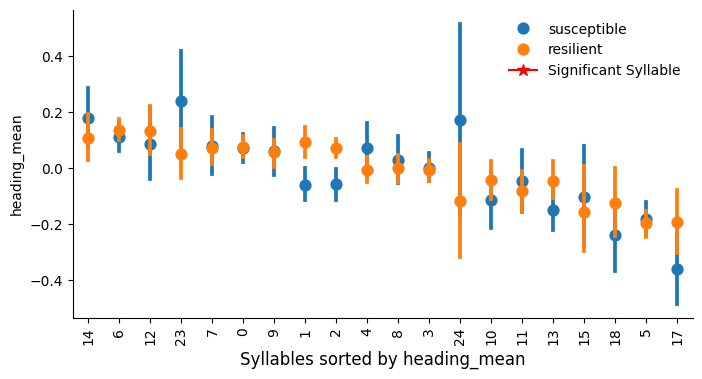

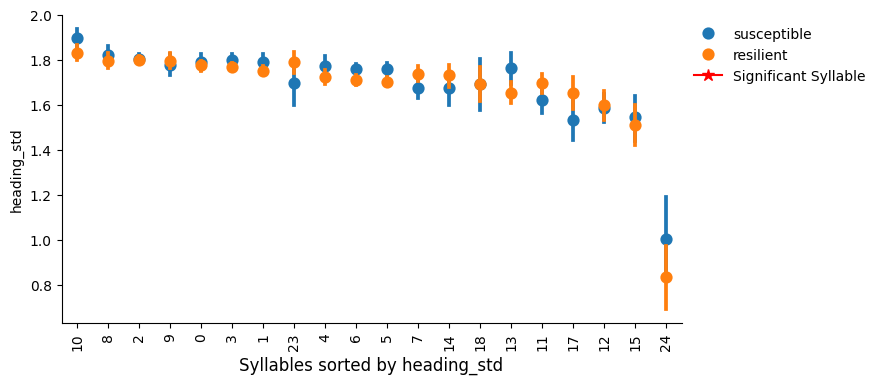

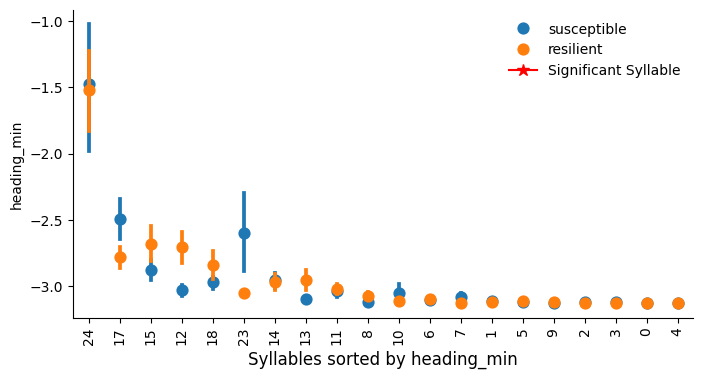

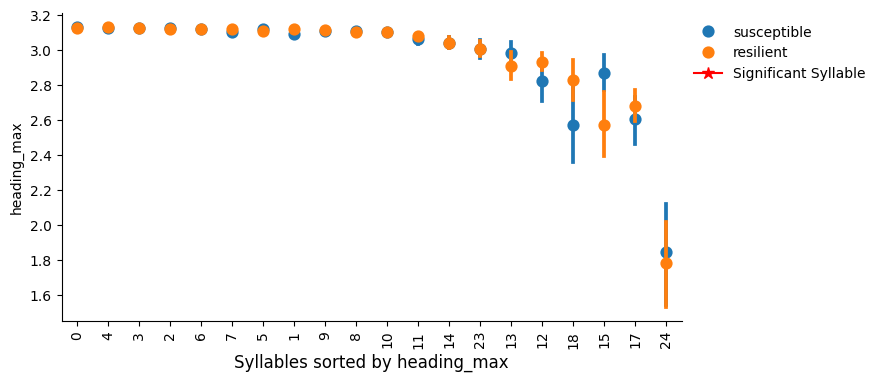

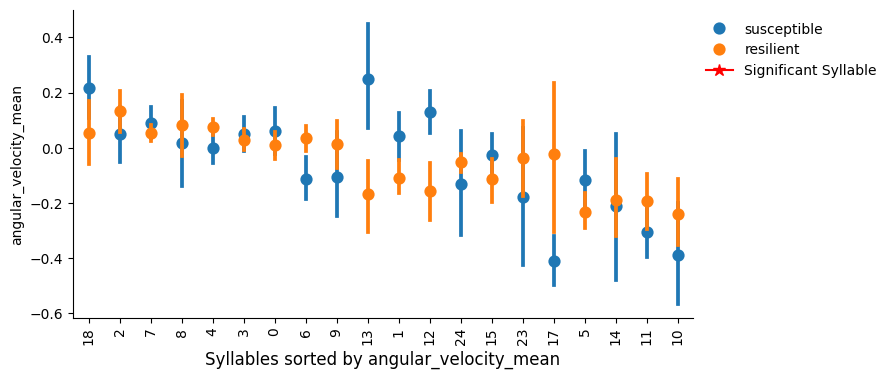

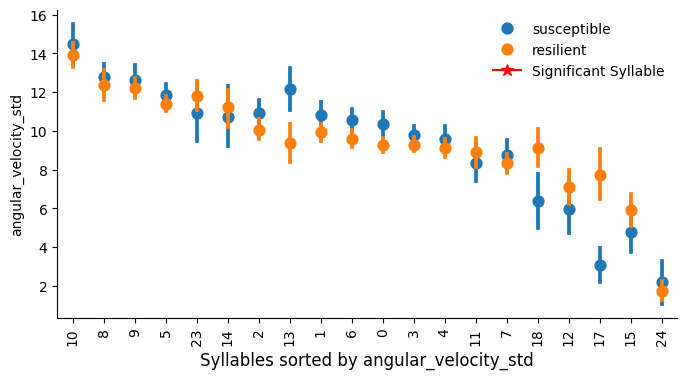

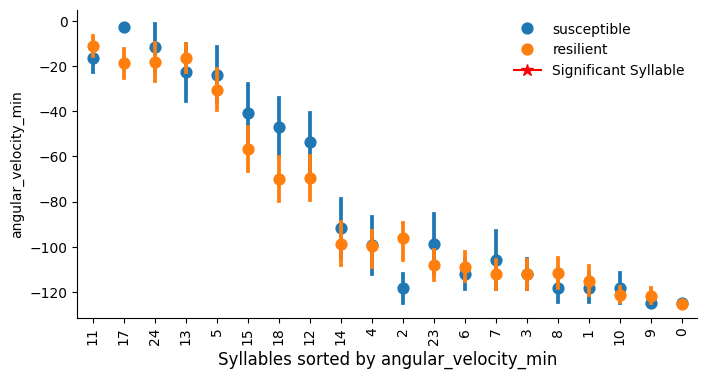

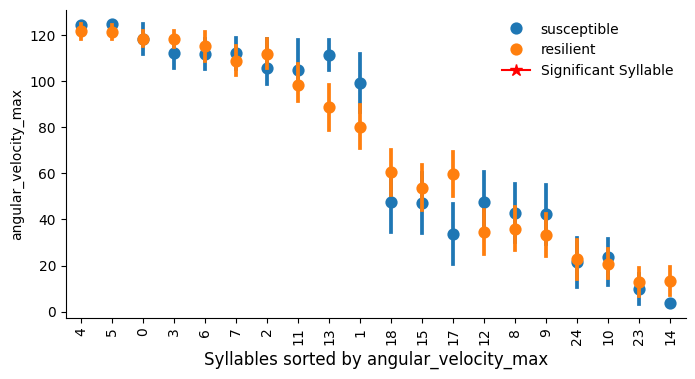

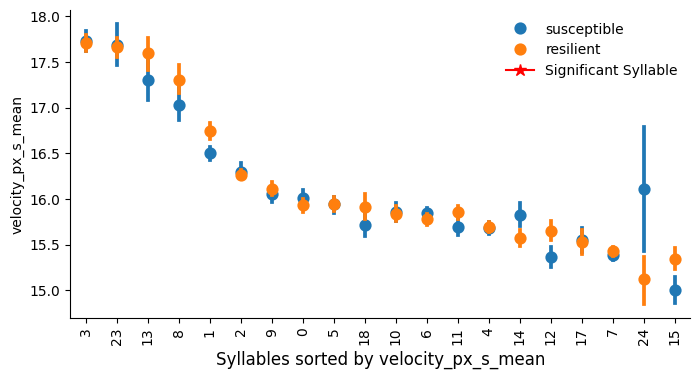

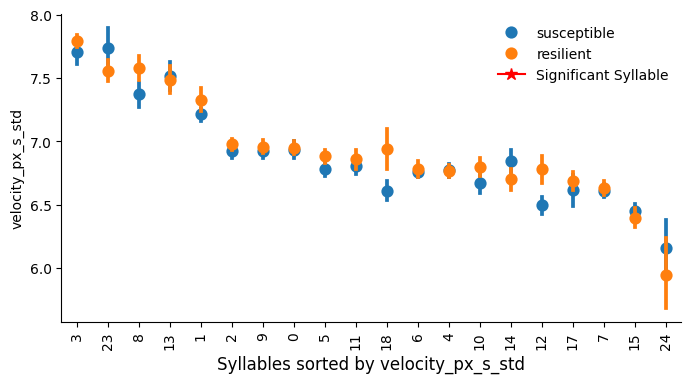

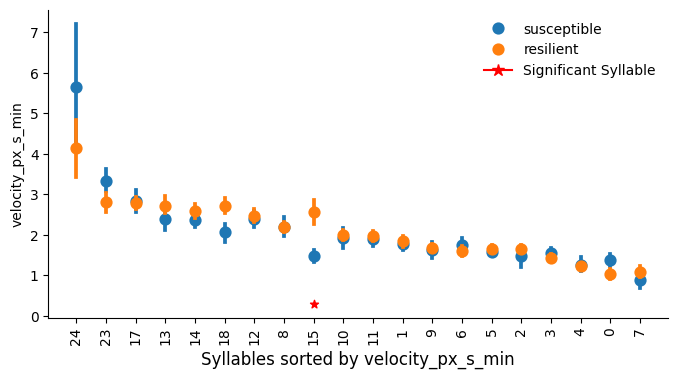

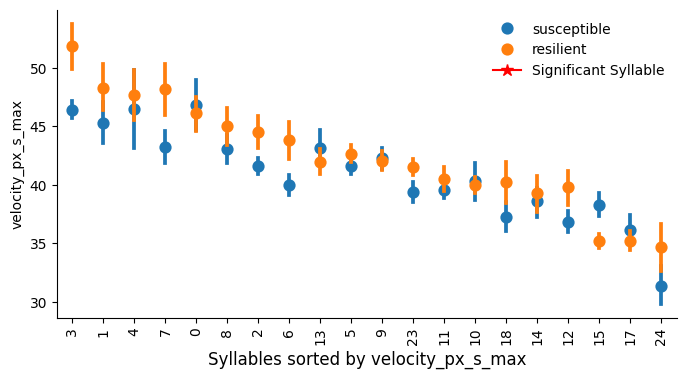

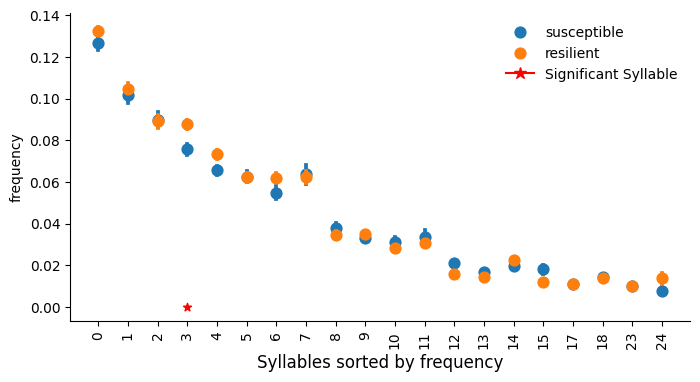

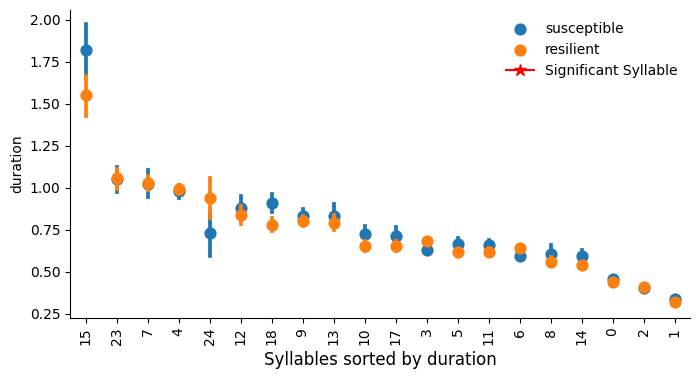

In [7]:
thresh=0.05   # p-value threshold
stats = ['heading_mean', 'heading_std',
       'heading_min', 'heading_max', 'angular_velocity_mean',
       'angular_velocity_std', 'angular_velocity_min', 'angular_velocity_max',
       'velocity_px_s_mean', 'velocity_px_s_std', 'velocity_px_s_min',
       'velocity_px_s_max', 'frequency', 'duration']

for stat in stats:
    kpms.plot_syll_stats_with_sem(
    stats_df, project_dir, model_name,
    plot_sig=True,    # whether to mark statistical significance with a star
    thresh=thresh,      # significance threshold
    stat=stat, #statistic to be plotted (e.g. 'duration' or 'velocity_px_s_mean')
    order='stat',     # order syllables by overall frequency ("stat") or degree of difference ("diff")
    ctrl_group=ctrl_group,   # name of the control group for statistical testing
    exp_group=exp_group,    # name of the experimental group for statistical testing
    figsize=(8, 4),   # figure size    
    join=False,   # whether to join syllables with a line
    groups=groups, # groups to be plotted
    #groups=stats_df['group'].unique(), # groups to be plotted
    )

In [9]:
stats = ['distance_from_origin','velocity_xy','velocity_z','length','height','torso_angle','angle_to_origin']
# postfix = ['mean', 'std','max','min']
postfix = ['mean']
stats2 = [f'{stat}_{post}' for stat in stats for post in postfix]
stats2 = stats2 + ['frequency','duration']

for stat2 in stats2:
    df_k_real, dunn_results_df, sig_pairs = kpms.run_kruskal(stats_df, statistic=stat2, thresh=0.05, mc_method='fdr_bh')
    # save df_k_real
    save_dir = os.path.join(project_dir, model_name) # directory to save the moseq_df dataframe
    df_k_real.to_csv(os.path.join(save_dir, f'kruskal_{stat2}_{stats_df_filename}.csv'), index=False, encoding='utf-8')

### Transition matrices
Generate heatmaps showing the transition frequencies between syllables.

기존 제공 코드: 전체 데이터를 concat후, TP 구한 후, bigram normalization해서 그룹의 평균을 구함.

아래 코드: 각 results csv 파일마다 TP 구한 후, bigram normalization한 후, 평균값을 내서 그룹의 평균을 구함. -> Syllable간 transition이 유독 많거나 적은 개체의 영향을 덜 받음.
selected_groups 설정 후 부터는 각 variable의 순서가 매우 중요하므로 수정할 때 주의할 것!!!! (가령, kpms.get_group_trans_mats_from_individual을 통해 return되는 variables는 mouse name, TP 등이 순서대로 배열됨) --> 나중에 dictionary형태로 변환 필요.

In [1]:
import keypoint_moseq as kpms
import os
import pandas as pd

project_dir=r'C:\Users\MyPC\Desktop\git\kp_moseq\keypoint-moseq\project\SDSBD\dataset5\trainset1' # the full path to the project directory
model_name='2024_01_04-13_41_21' # name of model to analyze (e.g. something like `2023_05_23-15_19_03`)
fps=20 # frames per second of the video
min_frequency = 0.01
exp_group='resilient'
ctrl_group='susceptible'
selected_groups = [exp_group, ctrl_group]  # selected_groups는 바꾸지 말기. group1, group2를 선택하기 위해 사용

# 데이터 로드 및 전처리
index_filename = "index_z1.5.csv"
results_dict = kpms.load_results(project_dir, model_name)
results_dict = kpms.extract_matching_results(csv_file=os.path.join(project_dir,index_filename), results_dict=results_dict)
index_filepath = os.path.join(project_dir, index_filename)
index_data = pd.read_csv(index_filepath, index_col=False)
normalize = 'bigram'


In [2]:
# 아래 module에는 selected_groups를 사용하지 않기. 왜냐면 selected_groups에서의 min_frequency 이상의 syllable만 사용하기 때문. 
# 실제 앞에서의 분석에서는 index.csv에 있는 모든 개체에 대해 frequency를 계산하기 때문에, 이를 기준으로 syllable을 선택해야 함.
group_tps, usages, individual_tps, label_group, recordings, syll_include, group_list = kpms.get_group_trans_mats_from_individual(
    project_dir, model_name, index_data, results_dict=results_dict, normalize=normalize, min_frequency=min_frequency, normalize_individual_tp='bigram')

print(group_list)

# group_list에서 selected_groups의 index를 찾아서 group_tps에서 해당 index의 transition matrix만 추출 (selected_groups의 순서대로)
group_tps_index = [group_list.index(group) for group in selected_groups] 
group_tps = [group_tps[i] for i in group_tps_index]

['control', 'resilient', 'susceptible']


In [ ]:
kpms.visualize_save_each_transition_bigram(
    project_dir, model_name, selected_groups, group_tps, syll_include, normalize=normalize,
    show_syllable_names=True
)

In [4]:
# Run and Save statistics result
thres = 0.05    # p-value threshold
thres_fdr_bh = 0.25 # Q value for statistical significance (bh-fdr correction)

transition_results_df = kpms.run_permutation_group_tps(project_dir, model_name, group_tps, individual_tps, label_group, syll_include, selected_groups, n_resamples=2000, threshold=thres, threshold_fdr=thres_fdr_bh)

# Import the result
#transition_results_df = pd.read_csv(r'G:\공유 드라이브\Broad X ACTNOVA\kp-moseq\trial2_without_nose_tip\2024_03_27-21_14_34\Transition_SETD1A_HET_M_vs_SETD1A_WT_M\transition_results.csv')

Significant transitions between resilient and susceptible (without correction):
Syllable 3 -> Syllable 4
Syllable 5 -> Syllable 3
Syllable 8 -> Syllable 3
Syllable 8 -> Syllable 11
Syllable 8 -> Syllable 12
Syllable 8 -> Syllable 15
Syllable 10 -> Syllable 0
Syllable 10 -> Syllable 4
Syllable 11 -> Syllable 6
Syllable 12 -> Syllable 10
Syllable 12 -> Syllable 15
Syllable 23 -> Syllable 2
Syllable 24 -> Syllable 14

Significant transitions between resilient and susceptible (with correction):



In [3]:
## 기존 코드. project_dir과 model_name에 있는 모든 데이터셋 분석.

## 주의! trsans_mats, usages의 경우 index (0,1,2,...)가 groups의 순서대로. groups 이름이 key로 할당되는게 아님.
## 따라서 kpms.generate_transition_matrices()의 output인 groups를 임의로 groups=['resilient','susceptible'] 등으로 바꾸지 말기.

# index_filename = "index_all.csv"
# normalize='bigram' # normalization method ("bigram", "rows" or "columns")

# trans_mats, usages, groups, syll_include=kpms.generate_transition_matrices(
#     project_dir, model_name, normalize=normalize,
#     min_frequency=0.005, # minimum syllable frequency to include
#     index_filename=index_filename
# )    

# kpms.visualize_save_each_transition_bigram(
#     project_dir, model_name, groups, trans_mats, syll_include, normalize=normalize, 
#     show_syllable_names=True # label syllables by index (False) or index and name (True)
# )

Group(s): GRIA3_MUT_M, GRIA3_WT_M, SETD1A_HET_F, SETD1A_HET_M, SETD1A_WT_F, SETD1A_WT_M


### Syllable Transition Graph
Render transition rates in graph form, where nodes represent syllables and edges represent transitions between syllables, with edge width showing transition rate for each pair of syllables (secifically the max of the two transition rates in each direction).

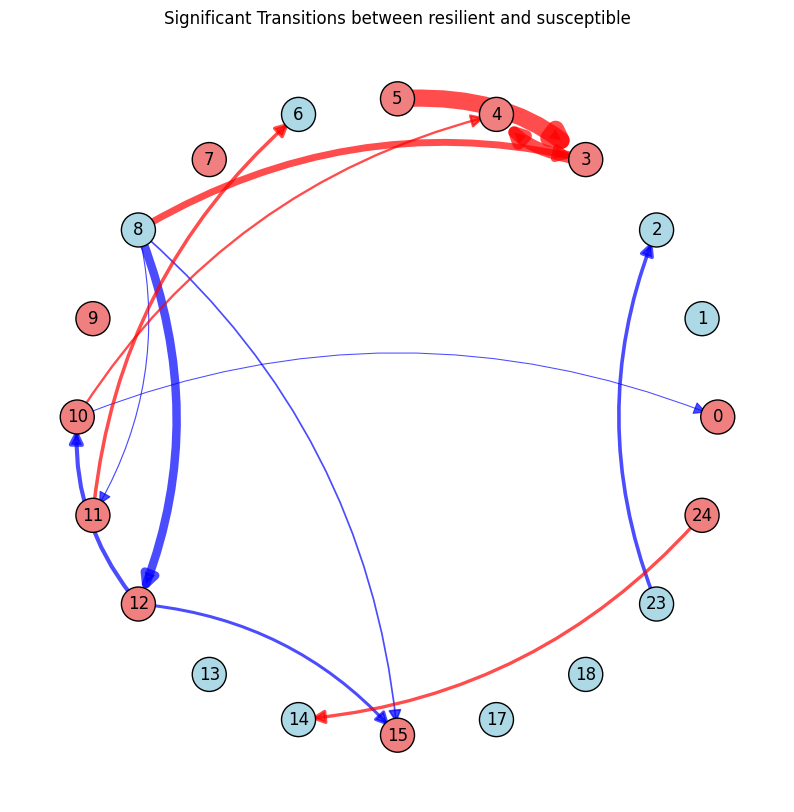

In [4]:
kpms.plot_significant_transition_graph(project_dir, model_name, selected_groups[0], selected_groups[1], 
                                       transition_results_df, syll_include, usages, layout='circular', node_scaling=2000, show_syllable_names=True, legend=False)


In [6]:
root_syll = 12
individual_tps_root = kpms.individual_transitions_based_root_syll(project_dir, model_name, root_syll, individual_tps, label_group, recordings, syll_include)
transition_results_df_root_syll = kpms.run_permutation_group_tps_root_syll(project_dir, model_name, individual_tps_root, root_syll, selected_groups, threshold_fdr=0.25)

Significant transitions between resilient and susceptible (without correction):
['Outgoing 6', 'Incoming 9', 'Outgoing 15']

Significant transitions between resilient and susceptible (with correction):
[]


In [7]:
# 확정. 배열만 순서대로. 작업중

import numpy as np
import pandas as pd
import plotly.graph_objects as go
import os

def create_sankey_diagram_from_individual_tps(project_dir, model_name, individual_tps_root, transition_results_df_root_syll, root_syllable, syll_include, group_names):
    """
    Create Sankey diagrams for the given root syllable using individual transition probabilities.
    
    Args:
    project_dir (str): Project directory path.
    model_name (str): Name of the model.
    individual_tps_root (pd.DataFrame): DataFrame of individual transitions from individual_transitions_based_root_syll.
    transition_results_df_root_syll (pd.DataFrame): DataFrame containing the permutation test results.
    root_syllable (int): The root syllable (i.e. 3).
    syll_include (np.array): Array of syllable indices.
    group_names (list): List of group names.

    Returns:
    None (Saves Sankey diagrams as HTML, PNG, and PDF files)
    """
    # Data validation
    expected_transitions = set([f"Incoming {s}" for s in syll_include if s != root_syllable] +
                               [f"Outgoing {s}" for s in syll_include if s != root_syllable])
    actual_transitions = set(transition_results_df_root_syll['Transition'])
    
    if expected_transitions != actual_transitions:
        print("Error: Mismatch between expected and actual transitions in transition_results_df_root_syll.")
        print("This might indicate that the root_syllable does not match the transition data.")
        print("Expected transitions:", expected_transitions)
        print("Actual transitions:", actual_transitions)
        return
    
    # check whether the individual_tps_root has columns for 'incoming_{root_syllable}' and 'outgoing_{root_syllable}'
    if f'incoming_{root_syllable}' in individual_tps_root.columns or f'outgoing_{root_syllable}' in individual_tps_root.columns:
        print(f"Error: individual_tps_root should not contain columns for 'incoming_{root_syllable}' and 'outgoing_{root_syllable}'.")
        print("This might indicate that the root_syllable does not match the individual transition data.")
        print("Run codes from the first cell to generate the correct individual_tps_root.")
        return
    
    syll_include_except_root = syll_include[syll_include != root_syllable] # remove root_syllable from syll_include
    root_index = np.where(syll_include == root_syllable)[0][0]
    for group_name in group_names:
        # Filter data for the current group
        group_data = individual_tps_root[individual_tps_root['group'] == group_name]
        
        # Calculate mean transition probabilities for the group
        incoming_cols = [col for col in group_data.columns if col.startswith('incoming_')]
        outgoing_cols = [col for col in group_data.columns if col.startswith('outgoing_')]
        
        incoming = group_data[incoming_cols].mean().values
        outgoing = group_data[outgoing_cols].mean().values
        
        source = []
        target = []
        value = []
        color = []
        color_node = (len(syll_include)-1 + 1 + len(syll_include)-1) * ['rgba(0, 0, 0, 0.5)']  # Basic node color (transparent black)
        
        label = [f"{s}" for s in syll_include_except_root] + [f"{root_syllable}"] + [f"{s}" for s in syll_include_except_root]  # Label for each node (incoming + root + outgoing)
        
        # Incoming transitions
        for i, prob in enumerate(incoming):
            from_syll = syll_include[i] if i < root_index else syll_include[i+1]
            source.append(i)
            target.append(len(syll_include)-1)
            value.append(max(prob, 0.0001))  # To avoid zero division
            if prob < 0.01:  # find the position of value=0.1 and change the same position of the label into ''
                label[i] = ''
            
            transition = f"Incoming {from_syll}"
            
            significance = transition_results_df_root_syll.loc[
                transition_results_df_root_syll['Transition'] == transition, 
                'Significant'
            ].values[0]
            
            if significance:
                tp_diff = transition_results_df_root_syll.loc[
                    transition_results_df_root_syll['Transition'] == transition, 
                    f'TP_diff_{group_names[0]}-{group_names[1]}'
                ].values[0]
                
                if tp_diff > 0:
                    color.append('rgba(62, 140, 87, 0.2)')  # transparent green
                    color_node[i] = 'rgba(62, 140, 87, 0.5)'  # Green
                else:
                    color.append('rgba(229, 180, 75, 0.2)')  # transparent yellow
                    color_node[i] = 'rgba(229, 180, 75, 0.5)'  # Yellow
            else:
                color.append('rgba(0, 0, 0, 0.2)')  # Transparent black

        # Outgoing transitions
        for i, prob in enumerate(outgoing):
            to_syll = syll_include[i] if i < root_index else syll_include[i+1]
            source.append(len(syll_include)-1)
            target.append(len(syll_include) + i)
            value.append(max(prob, 0.0001))  # To avoid zero division
            if prob < 0.01:  # find the position of value=0.1 and change the same position of the label into ''
                label[len(syll_include) + i] = ''
            
            transition = f"Outgoing {to_syll}"
            
            significance = transition_results_df_root_syll.loc[
                transition_results_df_root_syll['Transition'] == transition, 
                'Significant'
            ].values[0]
            
            if significance:
                tp_diff = transition_results_df_root_syll.loc[
                    transition_results_df_root_syll['Transition'] == transition, 
                    f'TP_diff_{group_names[0]}-{group_names[1]}'
                ].values[0]
                
                if tp_diff > 0:
                    color.append('rgba(62, 140, 87, 0.2)')  # transparent green
                    color_node[len(syll_include) + i] = 'rgba(62, 140, 87, 0.5)'  # Green
                else:
                    color.append('rgba(229, 180, 75, 0.2)')  # transparent yellow
                    color_node[len(syll_include) + i] = 'rgba(229, 180, 75, 0.5)'  # Yellow
            else:
                color.append('rgba(0, 0, 0, 0.2)')  # Transparent black
        # Calculate node positions and heights
        n_nodes = len(syll_include)
        x_positions = []
        y_positions = []
        node_heights = []
        
        def calculate_node_positions(values, start_y=0.1, end_y=0.9):
            n = len(values)
            if n == 0:
                return [], []
            
            total_value = sum(values) + 1e-10  # Add small value to avoid division by zero
            min_height = 0.001  # Minimum node height
            
            # Calculate node heights
            heights = [max(v / total_value * (end_y - start_y), min_height) for v in values]
            
            # Calculate positions
            positions = []
            current_y = start_y
            for height in heights:
                positions.append(current_y + height / 2)
                current_y += height + 0.01  # Add small gap between nodes
            
            return positions

        # Left side nodes (incoming)
        left_y_positions = calculate_node_positions(incoming)
        x_positions.extend([0.1] * (n_nodes - 1))
        y_positions.extend(left_y_positions)
        
        # Root node
        x_positions.append(0.5)
        y_positions.append(0.5)
        node_heights.append(0.1)  # Fixed height for root node
        
        # Right side nodes (outgoing)
        right_y_positions = calculate_node_positions(outgoing)
        x_positions.extend([0.9] * (n_nodes - 1))
        y_positions.extend(right_y_positions)
            
        color_node[len(syll_include)-1] = 'blue'  # Root node color

        fig = go.Figure(data=[go.Sankey(
            node = dict(
              pad = 10,
              thickness = 100,
              line = dict(color = "black", width = 0.5),
              label = label,
              color = color_node,
              x = x_positions,
              y = y_positions
            ),
            link = dict(
              source = source,
              target = target,
              value = value,
              color = color,
              line = dict(color = "white", width = 0.5)
          ))])

        fig.update_layout(title_text=f"Transition Probabilities for Syllable {root_syllable} ({group_name})", font_size=20, height=800, width=800)

        # Save the figure
        save_dir = os.path.join(project_dir, model_name, "sankey_diagrams")
        os.makedirs(save_dir, exist_ok=True)
        fig.write_html(os.path.join(save_dir, f"sankey_{group_name}_syllable_{root_syllable}.html"))
        fig.write_image(os.path.join(save_dir, f"sankey_{group_name}_syllable_{root_syllable}.png"))
        fig.write_image(os.path.join(save_dir, f"sankey_{group_name}_syllable_{root_syllable}.pdf"))

In [8]:
create_sankey_diagram_from_individual_tps(project_dir, model_name, individual_tps_root, transition_results_df_root_syll, root_syll, syll_include, selected_groups)

In [ ]:
    # root_syllable=3    
    # group_names = ['resilient', 'susceptible']
    # syll_include_except_root = syll_include[syll_include != root_syllable] # remove root_syllable from syll_include
    # root_index = np.where(syll_include == root_syllable)[0][0]
    # for group_name in group_names:
    #     # Filter data for the current group
    #     group_data = individual_tps_root[individual_tps_root['group'] == group_name]
        
    #     # Calculate mean transition probabilities for the group
    #     incoming_cols = [col for col in group_data.columns if col.startswith('incoming_')]
    #     outgoing_cols = [col for col in group_data.columns if col.startswith('outgoing_')]
        
    #     incoming = group_data[incoming_cols].mean().values
    #     outgoing = group_data[outgoing_cols].mean().values
        
    #     source = []
    #     target = []
    #     value = []
    #     color = []
    #     color_node = (len(syll_include)-1 + 1 + len(syll_include)-1) * ['rgba(0, 0, 0, 0.5)']  # Basic node color (transparent black)

    #     # Incoming transitions
    #     for i, prob in enumerate(incoming):
    #         from_syll = syll_include[i] if i < root_index else syll_include[i+1]
    #         source.append(i)
    #         target.append(len(syll_include)-1)
    #         value.append(max(prob, 0.0001))  # To avoid zero division
            
    #         transition = f"Incoming {from_syll}"
            
    #         significance = transition_results_df_root_syll.loc[
    #             transition_results_df_root_syll['Transition'] == transition, 
    #             'Significant'
    #         ].values[0]
            
    #         if significance:
    #             tp_diff = transition_results_df_root_syll.loc[
    #                 transition_results_df_root_syll['Transition'] == transition, 
    #                 f'TP_diff_{group_names[0]}-{group_names[1]}'
    #             ].values[0]
                
    #             if tp_diff > 0:
    #                 color.append('rgba(62, 140, 87, 0.2)')  # transparent green
    #                 color_node[i] = 'rgba(62, 140, 87, 0.5)'  # Green
    #             else:
    #                 color.append('rgba(229, 180, 75, 0.2)')  # transparent yellow
    #                 color_node[i] = 'rgba(229, 180, 75, 0.5)'  # Yellow
    #         else:
    #             color.append('rgba(0, 0, 0, 0.2)')  # Transparent black

    #     # Outgoing transitions
    #     for i, prob in enumerate(outgoing):
    #         to_syll = syll_include[i] if i < root_index else syll_include[i+1]
    #         source.append(len(syll_include)-1)
    #         target.append(len(syll_include) + i)
    #         value.append(max(prob, 0.0001))  # To avoid zero division
            
    #         transition = f"Outgoing {to_syll}"
            
    #         significance = transition_results_df_root_syll.loc[
    #             transition_results_df_root_syll['Transition'] == transition, 
    #             'Significant'
    #         ].values[0]
            
    #         if significance:
    #             tp_diff = transition_results_df_root_syll.loc[
    #                 transition_results_df_root_syll['Transition'] == transition, 
    #                 f'TP_diff_{group_names[0]}-{group_names[1]}'
    #             ].values[0]
                
    #             if tp_diff > 0:
    #                 color.append('rgba(62, 140, 87, 0.2)')  # transparent green
    #                 color_node[len(syll_include) + i] = 'rgba(62, 140, 87, 0.5)'  # Green
    #             else:
    #                 color.append('rgba(229, 180, 75, 0.2)')  # transparent yellow
    #                 color_node[len(syll_include) + i] = 'rgba(229, 180, 75, 0.5)'  # Yellow
    #         else:
    #             color.append('rgba(0, 0, 0, 0.2)')  # Transparent black

    #     # Calculate node positions
    #     n_nodes = len(syll_include)
    #     x_positions = []
    #     y_positions = []
        
    #     # Left side nodes (incoming)
    #     for i in range(n_nodes - 1):
    #         x_positions.append(0.1)
    #         y_positions.append(0.3)
        
    #     # Root node
    #     x_positions.append(0.5)
    #     y_positions.append(0.5)
        
    #     # Right side nodes (outgoing)
    #     for i in range(n_nodes - 1):
    #         x_positions.append(1)
    #         y_positions.append((i / (n_nodes - 1)))
            
    #     label = [f"{s}" for s in syll_include_except_root] + [f"{root_syllable}"] + [f"{s}" for s in syll_include_except_root]  # Label for each node (incoming + root + outgoing)
    #     color_node[len(syll_include)-1] = 'blue'  # Root node color

    #     fig = go.Figure(data=[go.Sankey(
    #         node = dict(
    #           pad = 15,
    #           thickness = 20,
    #           line = dict(color = "black", width = 0.5),
    #           label = label,
    #           color = color_node,
    #           x = x_positions,
    #           y = y_positions
    #         ),
    #         link = dict(
    #           source = source,
    #           target = target,
    #           value = value,
    #           color = color,
    #           line = dict(color = "white", width = 0.5)
    #       ))])

In [ ]:
import numpy as np
import pandas as pd
import plotly.graph_objects as go
import os

def create_sankey_diagram(root_syllable, transition_matrix, syll_include, project_dir, model_name, group_name, transition_results_df):
    """
    Create a Sankey diagram for the given root syllable.
    
    Args:
    root_syllable (int): The root syllable (i.e. 3).
    transition_matrix (np.array): The transition probability matrix.
    syll_include (np.array): Array of syllable indices.
    project_dir (str): Project directory path.
    model_name (str): Name of the model.
    group_name (str): Name of the group.
    """
    root_index = np.where(syll_include == root_syllable)[0][0]
    
    incoming = transition_matrix[:, root_index]
    outgoing = transition_matrix[root_index, :]
    
    # Normalize incoming and outgoing probabilities
    incoming_sum = np.sum(incoming)
    outgoing_sum = np.sum(outgoing)
    
    if incoming_sum > 0:
        incoming = incoming / incoming_sum
    if outgoing_sum > 0:
        outgoing = outgoing / outgoing_sum

    source = []
    target = []
    value = []
    color = []
    color_node = (len(syll_include) + 1 + len(syll_include))* ['rgba(0, 0, 0, 0.5)']  # Basic node color (transparent black)

    # Incoming transitions
    for i, prob in enumerate(incoming):
        if i != root_index:
            source.append(i)
            target.append(len(syll_include))
            if prob > 0:
                value.append(prob)
            else:
                value.append(0.0001)  # To avoid zero division
            if transition_results_df.loc[(transition_results_df['From'] == syll_include[i]) & 
                                         (transition_results_df['To'] == root_syllable), 'Significance'].values[0] == 1: # Significant transition (p < 0.05) from tansition_results_df
                if transition_results_df.loc[(transition_results_df['From'] == syll_include[i]) & 
                                         (transition_results_df['To'] == root_syllable), 'TP_Diff'].values[0] > 0: # whether the resilient group has higher transition probability
                    color.append('rgba(62, 140, 87, 0.2)') # transparent green
                    color_node[i] = 'rgba(62, 140, 87, 0.5)' # Green
                else:
                    color.append('rgba(229, 180, 75, 0.2)') # transparent yellow
                    color_node[i] = 'rgba(229, 180, 75, 0.5)' # Yellow
            else:
                color.append('rgba(0, 0, 0, 0.2)')  # Transparent black
    
    # Outgoing transitions
    for i, prob in enumerate(outgoing):
        if i != root_index:
            source.append(len(syll_include))
            target.append((len(syll_include) + 1) + i)
            if prob > 0:
                value.append(prob)
            else:
                value.append(0.0001)  # To avoid zero divisions
            if transition_results_df.loc[(transition_results_df['From'] == root_syllable) & 
                                         (transition_results_df['To'] == syll_include[i]), 'Significance'].values[0] == 1: # Significant transition (p < 0.05) from tansition_results_df
                if transition_results_df.loc[(transition_results_df['From'] == root_syllable) &
                                                (transition_results_df['To'] == syll_include[i]), 'TP_Diff'].values[0] > 0:
                        color.append('rgba(62, 140, 87, 0.2)') # transparent green
                        color_node[len(syll_include) + 1 + i] = 'rgba(62, 140, 87, 0.5)' # Green
                else:
                        color.append('rgba(229, 180, 75, 0.2)') # transparent yellow
                        color_node[len(syll_include) + 1 + i] = 'rgba(229, 180, 75, 0.5)' # Yellow
            else:
                color.append('rgba(0, 0, 0, 0.2)')  # Transparent black
    
    label = [f"{s}" for s in syll_include] + [f"{root_syllable}"] + [f"{s}" for s in syll_include]  # Label for each node (incoming + root + outgoing)
    color_node[len(syll_include)] = 'blue'  # Root node color
    
    fig = go.Figure(data=[go.Sankey(
        node = dict(
          pad = 5,
          thickness = 45,
          line = dict(color = "white", width = 0.5),
          label = label,
          color = color_node
        ),
        link = dict(
          source = source,
          target = target,
          value = value,
          color = color,
          line = dict(color = "white", width = 0.5)
      ))])

    fig.update_layout(title_text=f"Transition Probabilities for Syllable {root_syllable} ({group_name})", font_size=10)

    # Save the figure
    save_dir = os.path.join(project_dir, model_name, "sankey_diagrams")
    os.makedirs(save_dir, exist_ok=True)
    fig.write_html(os.path.join(save_dir, f"sankey_{group_name}_syllable_{root_syllable}.html"))
    fig.write_image(os.path.join(save_dir, f"sankey_{group_name}_syllable_{root_syllable}.png"))
    fig.write_image(os.path.join(save_dir, f"sankey_{group_name}_syllable_{root_syllable}.pdf"))

def individual_transitions_based_root_syll(project_dir, model_name, root_syllable, individual_tps, label_group, recordings, syll_include, ):
    """
    Save individual mouse transitions for the given root syllable. 
    
    Args:
    root_syllable (int): The root syllable (i.e. 3).
    individual_tps (list): List of individual transition probability matrices.
    label_group (list): List of group labels for each recording.
    recordings (list): List of recording names.
    syll_include (np.array): Array of syllable indices.
    project_dir (str): Project directory path.
    model_name (str): Name of the model.

    Returns:
    df (pd.DataFrame): Dataframe of individual transitions.
    """
    root_index = np.where(syll_include == root_syllable)[0][0]
    
    data = []
    for i, tp in enumerate(individual_tps):
        incoming = tp[:, root_index]
        outgoing = tp[root_index, :]
        
        # Normalize incoming and outgoing probabilities
        incoming_sum = np.sum(incoming)
        outgoing_sum = np.sum(outgoing)
        if incoming_sum > 0:
            incoming = incoming / incoming_sum
        if outgoing_sum > 0:   
            outgoing = outgoing / outgoing_sum
        
        row = {'name': recordings[i], 'group': label_group[i]}
        for j, syll in enumerate(syll_include):
            if j != root_index:
                row[f'incoming_{syll}'] = incoming[j]
                row[f'outgoing_{syll}'] = outgoing[j]
        
        data.append(row)
    
    df = pd.DataFrame(data)
    
    # Save the dataframe
    save_dir = os.path.join(project_dir, model_name, "individual_transitions")
    os.makedirs(save_dir, exist_ok=True)
    df.to_csv(os.path.join(save_dir, f"individual_transitions_syllable_{root_syllable}.csv"), index=False)

    return df

def analyze_root_syllable(root_syllable, group_tps, individual_tps, label_group, syll_include, project_dir, model_name, selected_groups, transition_results_df):
    """
    Analyze the given root syllable: create Sankey diagrams and save individual transitions.
    
    Args:
    root_syllable (int): The root syllable (i.e. 3).
    group_tps (list): List of group transition matrices.
    individual_tps (list): List of individual transition probability matrices.
    label_group (list): List of group labels for each recording.
    syll_include (np.array): Array of syllable indices.
    project_dir (str): Project directory path.
    model_name (str): Name of the model.
    selected_groups (list): List of selected group names.
    """
    # Create Sankey diagrams for each group
    for i, group_tp in enumerate(group_tps):
        group_name = selected_groups[i]
        create_sankey_diagram(root_syllable, group_tp, syll_include, project_dir, model_name, group_name, transition_results_df)
    
    # Save individual transitions
    save_individual_transitions(root_syllable, individual_tps, label_group, syll_include, project_dir, model_name)

In [ ]:
# # 잘 돌아가는 예전 버전

# import numpy as np
# import pandas as pd
# import plotly.graph_objects as go
# import os

# def create_sankey_diagram(root_syllable, transition_matrix, syll_include, project_dir, model_name, group_name, transition_results_df):
#     """
#     Create a Sankey diagram for the given root syllable.
    
#     Args:
#     root_syllable (int): The root syllable (i.e. 3).
#     transition_matrix (np.array): The transition probability matrix.
#     syll_include (np.array): Array of syllable indices.
#     project_dir (str): Project directory path.
#     model_name (str): Name of the model.
#     group_name (str): Name of the group.
#     """
#     root_index = np.where(syll_include == root_syllable)[0][0]
    
#     incoming = transition_matrix[:, root_index]
#     outgoing = transition_matrix[root_index, :]
    
#     # Normalize incoming and outgoing probabilities
#     incoming_sum = np.sum(incoming)
#     outgoing_sum = np.sum(outgoing)
    
#     if incoming_sum > 0:
#         incoming = incoming / incoming_sum
#     if outgoing_sum > 0:
#         outgoing = outgoing / outgoing_sum

#     source = []
#     target = []
#     value = []
#     color = []
#     color_node = (len(syll_include) + 1 + len(syll_include))* ['rgba(0, 0, 0, 0.5)']  # Basic node color (transparent black)

#     # Incoming transitions
#     for i, prob in enumerate(incoming):
#         if i != root_index:
#             source.append(i)
#             target.append(len(syll_include))
#             if prob > 0:
#                 value.append(prob)
#             else:
#                 value.append(0.0001)  # To avoid zero division
#             if transition_results_df.loc[(transition_results_df['From'] == syll_include[i]) & 
#                                          (transition_results_df['To'] == root_syllable), 'Significance'].values[0] == 1: # Significant transition (p < 0.05) from tansition_results_df
#                 if transition_results_df.loc[(transition_results_df['From'] == syll_include[i]) & 
#                                          (transition_results_df['To'] == root_syllable), 'TP_Diff'].values[0] > 0: # whether the resilient group has higher transition probability
#                     color.append('rgba(62, 140, 87, 0.2)') # transparent green
#                     color_node[i] = 'rgba(62, 140, 87, 0.5)' # Green
#                 else:
#                     color.append('rgba(229, 180, 75, 0.2)') # transparent yellow
#                     color_node[i] = 'rgba(229, 180, 75, 0.5)' # Yellow
#             else:
#                 color.append('rgba(0, 0, 0, 0.2)')  # Transparent black
    
#     # Outgoing transitions
#     for i, prob in enumerate(outgoing):
#         if i != root_index:
#             source.append(len(syll_include))
#             target.append((len(syll_include) + 1) + i)
#             if prob > 0:
#                 value.append(prob)
#             else:
#                 value.append(0.0001)  # To avoid zero divisions
#             if transition_results_df.loc[(transition_results_df['From'] == root_syllable) & 
#                                          (transition_results_df['To'] == syll_include[i]), 'Significance'].values[0] == 1: # Significant transition (p < 0.05) from tansition_results_df
#                 if transition_results_df.loc[(transition_results_df['From'] == root_syllable) &
#                                                 (transition_results_df['To'] == syll_include[i]), 'TP_Diff'].values[0] > 0:
#                         color.append('rgba(62, 140, 87, 0.2)') # transparent green
#                         color_node[len(syll_include) + 1 + i] = 'rgba(62, 140, 87, 0.5)' # Green
#                 else:
#                         color.append('rgba(229, 180, 75, 0.2)') # transparent yellow
#                         color_node[len(syll_include) + 1 + i] = 'rgba(229, 180, 75, 0.5)' # Yellow
#             else:
#                 color.append('rgba(0, 0, 0, 0.2)')  # Transparent black
    
#     label = [f"{s}" for s in syll_include] + [f"{root_syllable}"] + [f"{s}" for s in syll_include]  # Label for each node (incoming + root + outgoing)
#     color_node[len(syll_include)] = 'blue'  # Root node color
    
#     fig = go.Figure(data=[go.Sankey(
#         node = dict(
#           pad = 5,
#           thickness = 45,
#           line = dict(color = "white", width = 0.5),
#           label = label,
#           color = color_node
#         ),
#         link = dict(
#           source = source,
#           target = target,
#           value = value,
#           color = color,
#           line = dict(color = "white", width = 0.5)
#       ))])

#     fig.update_layout(title_text=f"Transition Probabilities for Syllable {root_syllable} ({group_name})", font_size=10)

#     # Save the figure
#     save_dir = os.path.join(project_dir, model_name, "sankey_diagrams")
#     os.makedirs(save_dir, exist_ok=True)
#     fig.write_html(os.path.join(save_dir, f"sankey_{group_name}_syllable_{root_syllable}.html"))
#     fig.write_image(os.path.join(save_dir, f"sankey_{group_name}_syllable_{root_syllable}.png"))
#     fig.write_image(os.path.join(save_dir, f"sankey_{group_name}_syllable_{root_syllable}.pdf"))

# def save_individual_transitions(root_syllable, individual_tps, label_group, syll_include, project_dir, model_name):
#     """
#     Save individual mouse transitions for the given root syllable.
    
#     Args:
#     root_syllable (int): The root syllable (i.e. 3).
#     individual_tps (list): List of individual transition probability matrices.
#     label_group (list): List of group labels for each recording.
#     syll_include (np.array): Array of syllable indices.
#     project_dir (str): Project directory path.
#     model_name (str): Name of the model.
#     """
#     root_index = np.where(syll_include == root_syllable)[0][0]
    
#     data = []
#     for i, tp in enumerate(individual_tps):
#         incoming = tp[:, root_index]
#         outgoing = tp[root_index, :]
        
#         row = {'mouse_id': i, 'group': label_group[i]}
#         for j, syll in enumerate(syll_include):
#             if j != root_index:
#                 row[f'incoming_{syll}'] = incoming[j]
#                 row[f'outgoing_{syll}'] = outgoing[j]
        
#         data.append(row)
    
#     df = pd.DataFrame(data)
#     # Save the dataframe
#     save_dir = os.path.join(project_dir, model_name, "individual_transitions")
#     os.makedirs(save_dir, exist_ok=True)
#     df.to_csv(os.path.join(save_dir, f"individual_transitions_syllable_{root_syllable}.csv"), index=False)

#     return df
    


# def analyze_root_syllable(root_syllable, group_tps, individual_tps, label_group, syll_include, project_dir, model_name, selected_groups, transition_results_df):
#     """
#     Analyze the given root syllable: create Sankey diagrams and save individual transitions.
    
#     Args:
#     root_syllable (int): The root syllable (i.e. 3).
#     group_tps (list): List of group transition matrices.
#     individual_tps (list): List of individual transition probability matrices.
#     label_group (list): List of group labels for each recording.
#     syll_include (np.array): Array of syllable indices.
#     project_dir (str): Project directory path.
#     model_name (str): Name of the model.
#     selected_groups (list): List of selected group names.
#     """
#     # Create Sankey diagrams for each group
#     for i, group_tp in enumerate(group_tps):
#         group_name = selected_groups[i]
#         create_sankey_diagram(root_syllable, group_tp, syll_include, project_dir, model_name, group_name, transition_results_df)
    
#     # Save individual transitions
#     save_individual_transitions(root_syllable, individual_tps, label_group, syll_include, project_dir, model_name)

In [95]:
syll = 3
individual_tps[0][:,syll].sum(), individual_tps[0][syll,:].sum()


(0.07142857142857142, 0.08241758241758242)

In [96]:
root_syllable = 3  # Replace with your desired root syllable
analyze_root_syllable(root_syllable, group_tps, individual_tps, label_group, syll_include, project_dir, model_name, selected_groups, transition_results_df)

# 기존 코드 (transition prob.)

In [ ]:
# # Generate a transition graph for each single group

# kpms.plot_transition_graph_group(
#     project_dir, model_name, 
#     groups, trans_mats, usages, syll_include, 
#     layout='circular',        # transition graph layout ("circular" or "spring")
#     show_syllable_names=False # label syllables by index (False) or index and name (True)
# )

In [ ]:
# # Generate a difference-graph for each pair of groups.

# kpms.plot_transition_graph_difference(project_dir, model_name, 
#                                       groups, trans_mats, usages, syll_include, 
#                                       layout='circular') # transition graph layout ("circular" or "spring")